# HW2P2: Image Recognition and Verification

This is the second homework  in 11785: Introduction to Deep Learning. We are trying to tackle the problem of Image Verification. For this, we will need to first train our own CNN model to tackle the problem of classification, consisting of 8631 identities. Using this, we get the face embeddings for different pairs of images and try to identify if the pair of face matches or not.

# Libraries

In [1]:
!nvidia-smi # Run this to see what GPU you have

Sat Oct 12 09:24:50 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:C3:00.0 Off |                    0 |
| N/A   34C    P0    39W / 250W |   7470MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [57]:
import torch
from torchsummary import summary
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
import wandb
import matplotlib.pyplot as plt
from pytorch_metric_learning import samplers
import csv
import random
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


Device:  cuda


# Kaggle

# Config

In [58]:
config = {
    #global setting
    "model":"Densenet-3",
    'batch_size': 512, # Increase this if your GPU can handle it
    'lr': 0.0001,
    'epochs': 100, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    "label_smoothing":0.1,
    "percentage":1,
    # for Densnet
    "drop_rate":0.2,
    "growth_rate":32,
    "bottleneck":True,
    "num_blocks":4,
    "N_layer_each_block":[6,12,24,48],
    'data_dir': "/global/cfs/cdirs/m3578/jiayihua/11785/data/11-785-f24-hw2p2-verification/cls_data", #TODO
    'data_ver_dir': "/global/cfs/cdirs/m3578/jiayihua/11785/data/11-785-f24-hw2p2-verification/ver_data", #TODO
    'checkpoint_dir': "checkpoint" #TODO
    # Include other parameters as needed.
}

# Dataset

## Dataset Class for doing Image Verification

In [59]:
class ImagePairDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, csv_file, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs = []
        if csv_file.endswith('.csv'):
            with open(csv_file, 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i == 0:
                        continue
                    else:
                        self.pairs.append(row)
        else:
            with open(csv_file, 'r') as f:
                for line in f.readlines():
                    self.pairs.append(line.strip().split(' '))
                    

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):

        img_path1, img_path2, match = self.pairs[idx]
        img1 = Image.open(os.path.join(self.data_dir, img_path1))
        img2 = Image.open(os.path.join(self.data_dir, img_path2))
        return self.transform(img1), self.transform(img2), int(match)

In [60]:
class TestImagePairDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, csv_file, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs = []
        if csv_file.endswith('.csv'):
            with open(csv_file, 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i == 0:
                        continue
                    else:
                        self.pairs.append(row)
        else:
            with open(csv_file, 'r') as f:
                for line in f.readlines():
                    self.pairs.append(line.strip().split(' '))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):

        img_path1, img_path2 = self.pairs[idx]
        img1 = Image.open(os.path.join(self.data_dir, img_path1))
        img2 = Image.open(os.path.join(self.data_dir, img_path2))
        return self.transform(img1), self.transform(img2)

## Create Dataloaders for Image Recognition

In [61]:
from torch.utils.data import Subset

data_dir = config['data_dir']
# train_dir = os.path.join(data_dir)

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'dev')


def get_train_transforms():
    return torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomPerspective(distortion_scale=0.2,p=0.3),
        torchvision.transforms.GaussianBlur(kernel_size=3),
        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        torchvision.transforms.Resize(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.5116,0.4026,0.3519],std=[0.3073,0.2697,0.25871]),
        torchvision.transforms.RandomErasing(p=0.5,scale=(0.02,0.33))
    ])

# train transforms
train_transforms = get_train_transforms()

# val transforms
val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5116,0.4026,0.3519],std=[0.3073,0.2697,0.25871])])


# get datasets
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transforms)


val_dataset = torchvision.datasets.ImageFolder(val_dir, transform=val_transforms)

# normalize_transform = torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# cutmix_dataset = CutMixDataset(train_dataset, normalize=normalize_transform)


train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=config["batch_size"],
                                            shuffle=True,
                                            pin_memory=True,
                                            num_workers=4,
                                            sampler=None)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=config["batch_size"],
                                          shuffle=False,
                                          num_workers=4)


In [62]:
data_dir = config['data_ver_dir']


# get datasets

# TODO: Add your validation pair txt file
pair_dataset = ImagePairDataset(data_dir, csv_file='/global/cfs/cdirs/m3578/jiayihua/11785/data/11-785-f24-hw2p2-verification/val_pairs.txt', transform=val_transforms)
pair_dataloader = torch.utils.data.DataLoader(pair_dataset,
                                              batch_size=config["batch_size"],
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=4)

# TODO: Add your validation pair txt file
test_pair_dataset = TestImagePairDataset(data_dir, csv_file='/global/cfs/cdirs/m3578/jiayihua/11785/data/11-785-f24-hw2p2-verification/test_pairs.txt', transform=val_transforms)
test_pair_dataloader = torch.utils.data.DataLoader(test_pair_dataset,
                                              batch_size=config["batch_size"],
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=4)

# EDA and Viz

In [63]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(train_dataset.classes))
print("Number of classes val   : ",len(test_pair_dataset))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", val_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  8631
Number of classes val   :  6000
No. of train images  :  431550
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  256
Train batches        :  1686
Val batches          :  169


In [64]:
config["num_classes"]=len(train_dataset.classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

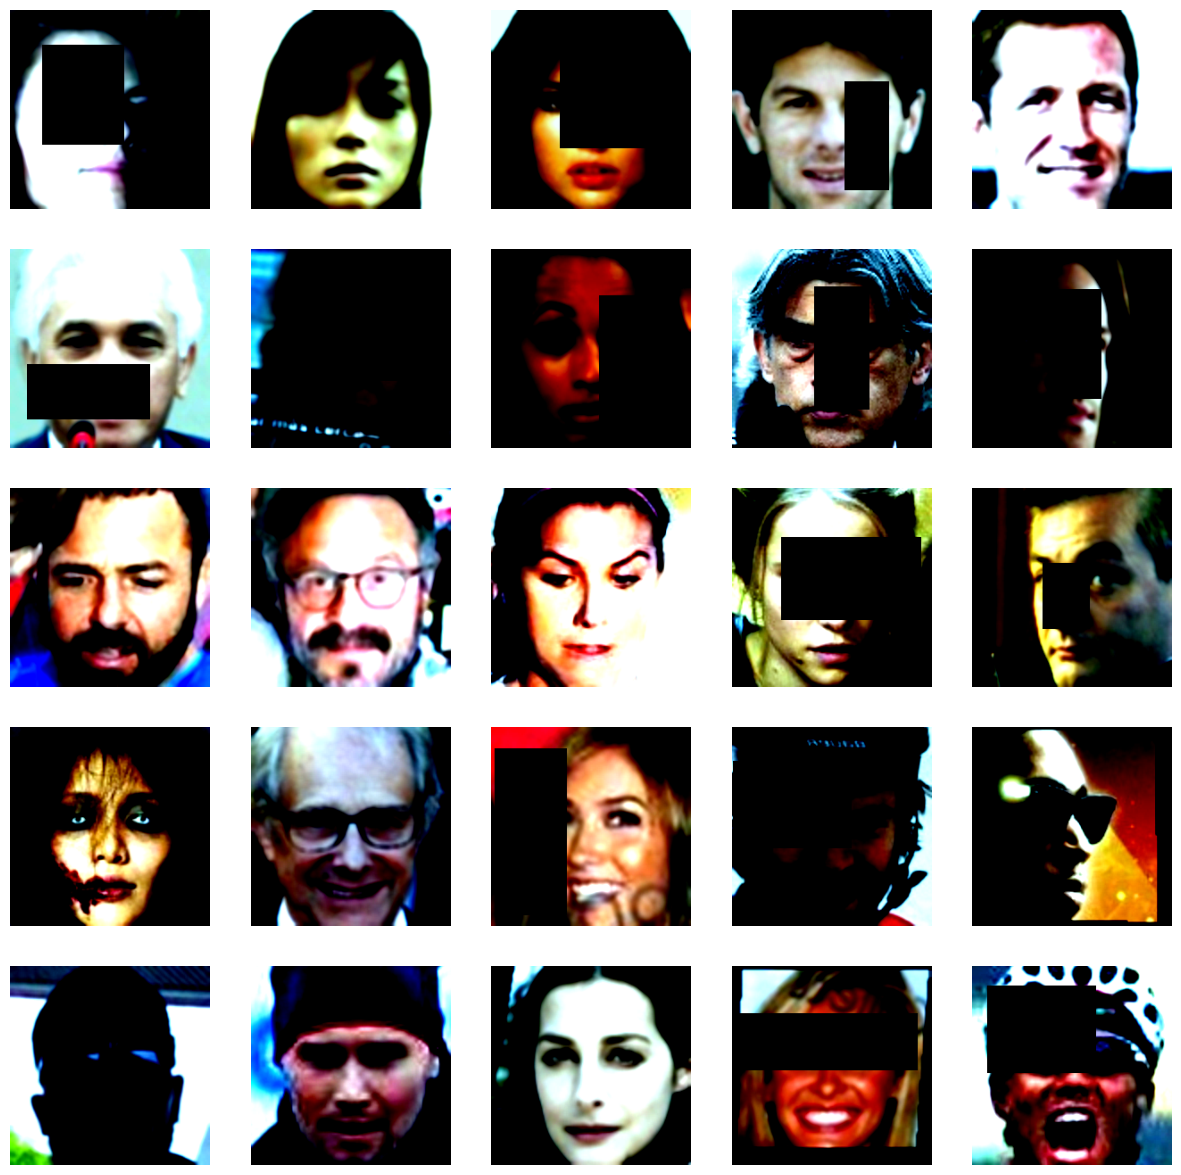

In [65]:
# Visualize a few images in the dataset

"""
You can write your own code, and you don't need to understand the code
It is highly recommended that you visualize your data augmentation as sanity check
"""

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(train_dir, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'],
    shuffle     = True)

for data in dtl:
    x, y = data
    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit is 18M.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next three have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 112x112. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

In [66]:
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

In [67]:
import torch
import torch.nn as nn

class DenseLayer(nn.Module):
    def __init__(self, input_channels, growth_rate, bottleneck=False, drop_rate=0.0):
        super(DenseLayer, self).__init__()
        self.bottleneck = bottleneck
        self.drop_rate = drop_rate

        if bottleneck:
            self.bn1 = nn.BatchNorm2d(input_channels)
            self.conv1 = nn.Conv2d(input_channels, 4 * growth_rate, kernel_size=1, stride=1, bias=False)
            nn.init.kaiming_normal_(self.conv1.weight)
            input_channels = 4 * growth_rate

        self.bn2 = nn.BatchNorm2d(input_channels)
        self.conv2 = nn.Conv2d(input_channels, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        nn.init.kaiming_normal_(self.conv2.weight)

        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(drop_rate) if drop_rate > 0 else None

    def forward(self, x):
        # Bottleneck layer
        out = self.relu(self.bn1(x)) if self.bottleneck else x
        out = self.conv1(out) if self.bottleneck else out
        
        # Main convolution
        out = self.relu(self.bn2(out))
        out = self.conv2(out)

        # Dropout if specified
        if self.dropout:
            out = self.dropout(out)

        # Concatenate input and output (dense connection)
        return torch.cat([x, out], 1)



In [68]:
class DenseBlock(nn.Module):
    def __init__(self, num_layers, input_channels, growth_rate, bottleneck=False, drop_rate=0.0):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()

        for i in range(num_layers):
            layer = DenseLayer(input_channels, growth_rate, bottleneck=bottleneck, drop_rate=drop_rate)
            self.layers.append(layer)
            input_channels += growth_rate

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


In [69]:

class TransitionLayer(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(input_channels)
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=1, bias=False)
        nn.init.kaiming_normal_(self.conv.weight)  # Proper initialization
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.relu(self.bn(x))
        x = self.conv(x)
        x = self.pool(x)
        return x


In [70]:

class DenseNet(nn.Module):
    def __init__(self, num_init_features=2*config["growth_rate"], num_classes=config["num_classes"],
                 growth_rate=config["growth_rate"], num_blocks=config["num_blocks"], 
                 num_layers_per_block=config["N_layer_each_block"], bottleneck=config["bottleneck"], 
                 drop_rate=config["drop_rate"]):
        super(DenseNet, self).__init__()
        
        # Initial Convolution
        self.init_conv = nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Dense Blocks with Transition Layers
        num_channels = num_init_features
        self.blocks = nn.ModuleList()
        
        for i in range(num_blocks):
            block = DenseBlock(num_layers=num_layers_per_block[i], input_channels=num_channels,
                               growth_rate=growth_rate, bottleneck=bottleneck, drop_rate=drop_rate)
            self.blocks.append(block)
            num_channels += num_layers_per_block[i] * growth_rate
            
            # Add transition layer between Dense Blocks, except the last block
            if i != num_blocks - 1:
                transition = TransitionLayer(input_channels=num_channels, output_channels=num_channels // 2)
                self.blocks.append(transition)
                num_channels = num_channels // 2

        # Final Batch Norm and Classification Layer
        self.bn = nn.BatchNorm2d(num_channels)
        self.fc = nn.Linear(num_channels, num_classes)

        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        x = self.init_conv(x)
        x = self.max_pool(x)
        
        for block in self.blocks:
            x = block(x)
        
        # Global Average Pooling
        x = F.relu(self.bn(x))
        x = F.adaptive_avg_pool2d(x, (1, 1))
        feats = torch.flatten(x, 1)
        out = self.fc(feats)
        
        # Return raw logits (no softmax applied here)
        return {"feats": feats, "out": out}
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)



In [71]:
model = DenseNet().to(DEVICE)
summary(model, (3, 224, 224))

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 39.39 GiB of which 1.12 MiB is free. Process 1583438 has 6.34 GiB memory in use. Process 476951 has 976.00 MiB memory in use. Including non-PyTorch memory, this process has 32.09 GiB memory in use. Of the allocated memory 31.43 GiB is allocated by PyTorch, and 165.20 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [45]:
# --------------------------------------------------- #

# Defining Loss Function
criterion = torch.nn.CrossEntropyLoss(label_smoothing=config["label_smoothing"])  # Good for multi-class classification, label smoothing helps regularize

# Defining Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], betas=(0.9, 0.999), eps=1e-08)  # AdamW works well, weight decay included

# Defining Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.1)  # Useful if loss plateaus

# Mixed Precision Training
scaler = torch.amp.GradScaler("cuda")  # Useful for supported GPUs to speed up training


# Metrics

In [46]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [47]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

In [48]:
def get_ver_metrics(labels, scores, FPRs):
    # eer and auc
    fpr, tpr, _ = mt.roc_curve(labels, scores, pos_label=1)
    roc_curve = interp1d(fpr, tpr)
    EER = 100. * brentq(lambda x : 1. - x - roc_curve(x), 0., 1.)
    AUC = 100. * mt.auc(fpr, tpr)

    # get acc
    tnr = 1. - fpr
    pos_num = labels.count(1)
    neg_num = labels.count(0)
    ACC = 100. * max(tpr * pos_num + tnr * neg_num) / len(labels)

    # TPR @ FPR
    if isinstance(FPRs, list):
        TPRs = [
            ('TPR@FPR={}'.format(FPR), 100. * roc_curve(float(FPR)))
            for FPR in FPRs
        ]
    else:
        TPRs = []

    return {
        'ACC': ACC,
        'EER': EER,
        'AUC': AUC,
        'TPRs': TPRs,
    }

# Train and Validation Function

In [49]:
def train_epoch(model, dataloader, optimizer, lr_scheduler, scaler, device, config, criterion):
    model.train()

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    # Progress Bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    for i, (images, labels) in enumerate(dataloader):
        optimizer.zero_grad()  # Zero gradients
        # Send data to device (e.g., GPU)
        images = images.to(device, non_blocking=True)
        if isinstance(labels, (tuple, list)):
            targets1, targets2, lam = labels
            targets1 = targets1.to(device, non_blocking=True)
            targets2 = targets2.to(device, non_blocking=True)
        else:
            labels = labels.to(device, non_blocking=True)

        # Forward pass with mixed precision (AMP)
        with torch.amp.autocast('cuda'):
            outputs = model(images)  # Model output, which is likely a tensor and not a dictionary
            # Check if CutMix was applied (multiple labels)
            if isinstance(labels, (tuple, list)):
                # Compute the CutMix loss as a weighted combination of both labels
                loss = lam * criterion(outputs["out"].float(), targets1.long()) + (1 - lam) * criterion(outputs["out"].float(), targets2.long())
            else:
                # Regular loss
                loss = criterion(outputs["out"].float(), labels.long())

        # Backward pass with gradient scaling for mixed precision
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Update loss metrics
        loss_m.update(loss.item())

        # Accuracy computation
        acc = accuracy(outputs["out"], targets1 if isinstance(labels, (tuple, list)) else labels)[0].item()
        acc_m.update(acc)

        # Update the progress bar
        batch_bar.set_postfix(
            acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss="{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )
        batch_bar.update()  # Update tqdm bar

    # Update learning rate scheduler if necessary
    if lr_scheduler is not None:
        lr_scheduler.step(loss.item())

    batch_bar.close()

    return acc_m.avg, loss_m.avg


In [50]:
@torch.no_grad()
def valid_epoch_cls(model, dataloader, device, config, criterion):

    model.eval()  # Set the model to evaluation mode (disables dropout, etc.)
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val Cls.')

    # Metric meters for loss and accuracy
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    for i, (images, labels) in enumerate(dataloader):
        # Move images and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Get model outputs
        outputs = model(images)
        loss = criterion(outputs["out"].float(), labels.long())

        # Metrics
        acc = accuracy(outputs["out"], labels)[0].item()
        loss_m.update(loss.item())
        acc_m.update(acc)

        # Update the progress bar
        batch_bar.set_postfix(
            acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss="{:.04f} ({:.04f})".format(loss.item(), loss_m.avg)
        )
        batch_bar.update()

    batch_bar.close()

    return acc_m.avg, loss_m.avg


In [51]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Verification Task

In [52]:
def valid_epoch_ver(model, pair_data_loader, device, config):

    model.eval()
    scores = []
    match_labels = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2, labels) in enumerate(pair_data_loader):

        # match_labels = match_labels.to(device)
        images = torch.cat([images1, images2], dim=0).to(device)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs["feats"], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.append(similarity.cpu().numpy())
        match_labels.append(labels.cpu().numpy())
        batch_bar.update()

    scores = np.concatenate(scores)
    match_labels = np.concatenate(match_labels)

    FPRs=['1e-4', '5e-4', '1e-3', '5e-3', '5e-2']
    metric_dict = get_ver_metrics(match_labels.tolist(), scores.tolist(), FPRs)
    print(metric_dict)

    return metric_dict['ACC']

# WandB

In [53]:
wandb.login(key="bc022b99e5a39b97fc6ae8c641ab328e9f52d2e6") # API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [54]:
# Create your wandb run
run = wandb.init(
    name = "Densenet_3_block", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)



# Checkpointing and Loading Model

In [55]:
# Uncomment the line for saving the scheduler save dict if you are using a scheduler
def save_model(model, optimizer, scheduler, metrics, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
        #  'scheduler_state_dict'     : scheduler.state_dict(),
         'metric'                   : metrics,
         'epoch'                    : epoch},
         path)


def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    metrics = checkpoint['metric']
    return model, optimizer, scheduler, epoch, metrics

In [56]:
# Getting the latest version of the artifact
artifact = run.use_artifact('{}:latest'.format(config['model']))
# Downloading the artifact
artifact_dir = artifact.download()
# Loading the model
model_dict = torch.load(os.path.join(artifact_dir, 'best_cls.pth'))
# Loading weights
model.load_state_dict(model_dict['model_state_dict'])
# Loading optimizer state
optimizer.load_state_dict(model_dict['optimizer_state_dict'])
# scheduler.load_state_dict(model_dict['scheduler_state_dict'])
# epoch.load_state_dict(model_dict['epoch_state_dict'])
# metrics.load_state_dict(model_dict['metrics_state_dict'])



wandb: Downloading large artifact Densenet-3:latest, 369.49MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.4
/tmp/ipykernel_1528831/3636065031.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues re

OutOfMemoryError: CUDA out of memory. Tried to allocate 68.00 MiB. GPU 0 has a total capacity of 39.39 GiB of which 31.12 MiB is free. Process 1583438 has 6.34 GiB memory in use. Process 476951 has 976.00 MiB memory in use. Including non-PyTorch memory, this process has 32.06 GiB memory in use. Of the allocated memory 31.40 GiB is allocated by PyTorch, and 168.67 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [29]:
# model, optimizer, scheduler, epoch, metrics = load_model(model,path="/kaggle/working/checkpoint/last.pth")

# Experiments

In [30]:
e = 0
best_valid_cls_acc = 0.0
eval_cls = True
best_valid_ret_acc = 0.0
for epoch in range(e, config['epochs']):
        # epoch
        print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

        # train
        train_cls_acc, train_loss = train_epoch(model, train_loader, optimizer, scheduler, scaler, DEVICE, config,criterion)
        curr_lr = float(optimizer.param_groups[0]['lr'])
        print("\nEpoch {}/{}: \nTrain Cls. Acc {:.04f}%\t Train Cls. Loss {:.04f}\t Learning Rate {:.04f}".format(epoch + 1, config['epochs'], train_cls_acc, train_loss, curr_lr))
        metrics = {
            'train_cls_acc': train_cls_acc,
            'train_loss': train_loss,
        }
        # classification validation
        if eval_cls:
            valid_cls_acc, valid_loss = valid_epoch_cls(model, val_loader, DEVICE, config,criterion)
            print("Val Cls. Acc {:.04f}%\t Val Cls. Loss {:.04f}".format(valid_cls_acc, valid_loss))
            metrics.update({
                'valid_cls_acc': valid_cls_acc,
                'valid_loss': valid_loss,
            })

        # retrieval validation
        valid_ret_acc = valid_epoch_ver(model, pair_dataloader, DEVICE, config)
        print("Val Ret. Acc {:.04f}%".format(valid_ret_acc))
        metrics.update({
            'valid_ret_acc': valid_ret_acc
        })

        # save model
        save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'last.pth'))
        print("Saved epoch model")
        
       

        # save best model
        if eval_cls:
            if valid_cls_acc >= best_valid_cls_acc:
                best_valid_cls_acc = valid_cls_acc
                save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                wandb.save(os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                print("Saved best classification model")
                model_artifact = wandb.Artifact(config['model'], type='model')

                # Adding model file to Artifact

                model_artifact.add_file(os.path.join(config['checkpoint_dir'], 'best_cls.pth'))

                # Saving Artifact to WandB

                run.log_artifact(model_artifact)

        if valid_ret_acc >= best_valid_ret_acc:
            best_valid_ret_acc = valid_ret_acc
            save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            wandb.save(os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            print("Saved best retrieval model")
         

        # log to tracker
        if run is not None:
            run.log(metrics)


Epoch 1/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 344.00 MiB. GPU 0 has a total capacity of 39.39 GiB of which 247.12 MiB is free. Process 1583438 has 6.34 GiB memory in use. Process 476951 has 976.00 MiB memory in use. Including non-PyTorch memory, this process has 31.85 GiB memory in use. Of the allocated memory 31.05 GiB is allocated by PyTorch, and 312.18 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Testing and Kaggle Submission (Verification)

In [ ]:
def test_epoch_ver(model, pair_data_loader, config):

    model.eval()
    scores = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2) in enumerate(pair_data_loader):

        images = torch.cat([images1, images2], dim=0).to(DEVICE)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs["feats"], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.extend(similarity.cpu().numpy().tolist())
        batch_bar.update()

    return scores

In [ ]:
scores = test_epoch_ver(model, test_pair_dataloader, config)

In [ ]:
with open("verification_early_submission.csv", "w+") as f:
    f.write("ID,Label\n")
    for i in range(len(scores)):
        f.write("{},{}\n".format(i, scores[i]))

In [ ]:
!kaggle competitions submit -c 11785-hw-2-p-2-face-verification-fall-2024 -f ./verification_early_submission.csv -m "Test Submission"
